In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [3]:
files =  glob.glob("../dados_*/*.dat")

In [4]:
len(files)

1320

In [5]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    return float(linhas[16400+7][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [6]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 276.3862706481477 dias


In [7]:
energias_iniciais_multicanal = ['1', '250', '400', '150', '300', '0']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [8]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [9]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith(energia_inicial_multicanal+'.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        n_particulas = float(partes[2].replace('estories','').replace('-','.'))
        dados_ = carrega_dados(file_, n_particulas)
        
        label_ = binarizer.transform([[nuclideo]])

        #Cria o label para o total de contagens do radionuclídeo
        total_counts = np.zeros(label_.shape)
        total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)
        
        dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({'X' : dados_.counts.values,
                                                                                 'n' : n_particulas,
                                                                                 'y': label_,
                                                                                 'y_count' : total_counts,
                                                                                 'd': distancia,
                                                                                 'e': energia_inicial_multicanal})

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Leituras experimentais da GRR

In [10]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [11]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [12]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [13]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [14]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.3:
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

## Com os dados experimentais

In [15]:
X = []
y = []
y_counts = []

In [16]:
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    how_many_combinations = 500
    if n_combinacao == 1:
        how_many_combinations = 1320
    for i in range(how_many_combinations):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)

In [17]:
len(X), len(y), len(y_counts)

(2820, 2820, 2820)

## Com os dados gerados pelo PENELOPE

In [18]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['y_count'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return values, labels, counts

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [19]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(500):
            values, labels, counts = gera_imagem_combinada_penelope(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values,
                                     'y': labels,
                                     'y_count': counts})

In [20]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [21]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [22]:
len(X), len(y), len(y_counts)

(14100, 14100, 14100)

# Modelo

## Dividindo os dados em treino e teste

In [23]:
scaler = StandardScaler()
scaler.fit(y_counts)

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, scaler.transform(y_counts))),
                                                    test_size=0.30,
                                                    random_state=42)

In [77]:
len(X_train), len(X_test), len(y_train), len(y_test)

(9870, 4230, 9870, 4230)

## Armazenando os dados originais

In [70]:
!mkdir dados_v3

In [74]:
np.save("./dados_v3/X.npy", [x.reshape((128,128,1)) for x in X])

In [76]:
np.save("./dados_v3/y_counts.npy", y_counts)

In [83]:
df_y = pd.DataFrame(y)
df_y.columns = nome_por_arquivo.keys()
df_y.groupby(list(nome_por_arquivo.keys())).count()

Empty DataFrame
Columns: []
Index: [(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0

In [25]:
from keras.utils import Sequence

In [26]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [27]:
s = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

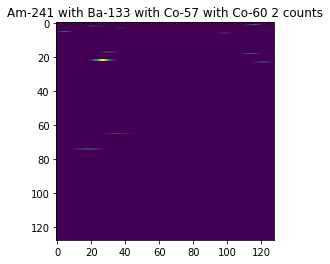

In [28]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.show()

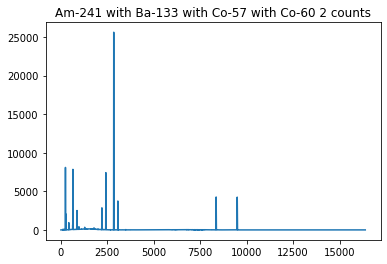

In [29]:
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.plot(a[0].reshape(-1))
plt.show()

In [30]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [31]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)

pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)

pred_counts = keras.layers.Dense(10, activation=None)(x1)

pred_counts = keras.layers.multiply([pred_counts, pred_nuclei], name="predictions_counts")

#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
_____________________________________

In [32]:
learning_rate = 1e-4
epochs = 250
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [33]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=opt,
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [34]:
!nvidia-smi

Sun Apr  5 18:30:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P5    16W / 180W |      0MiB /  8117MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [35]:
!rm -rf ./logs_v3

In [36]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=10)

tb = keras.callbacks.TensorBoard(
    log_dir='./logs_v3',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

#EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

callbacks = [es, tb]

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 114s - loss: 1.0539 - predictions_nuclei_loss: 0.5974 - predictions_counts_loss: 0.4565 - predictions_nuclei_my_accuracy_score: 0.0175 - predictions_nuclei_acc: 0.8238 - predictions_counts_mean_squared_error: 0.4565 - predictions_counts_mean_absolute_error: 0.3667 - val_loss: 0.8626 - val_predictions_nuclei_loss: 0.5443 - val_predictions_counts_loss: 0.3183 - val_predictions_nuclei_my_accuracy_score: 0.0272 - val_predictions_nuclei_acc: 0.8467 - val_predictions_counts_mean_squared_error: 0.3183 - val_predictions_counts_mean_absolute_error: 0.3031
Epoch 2/250
 - 112s - loss: 0.8089 - predictions_nuclei_loss: 0.5309 - predictions_counts_loss: 0.2779 - predictions_nuclei_my_accuracy_score: 0.0525 - predictions_nuclei_acc: 0.8510 - predictions_counts_mean_squared_error: 0.2779 - predictions_counts_mean_absolute_error: 0.2760 - val_loss: 0.7793 - val_predictions_nuclei_loss: 0.5183 - val_predictions_counts_loss: 0.2611 - val_pre

Epoch 15/250
 - 112s - loss: 0.4386 - predictions_nuclei_loss: 0.3182 - predictions_counts_loss: 0.1204 - predictions_nuclei_my_accuracy_score: 0.1370 - predictions_nuclei_acc: 0.8877 - predictions_counts_mean_squared_error: 0.1204 - predictions_counts_mean_absolute_error: 0.1871 - val_loss: 0.4348 - val_predictions_nuclei_loss: 0.3151 - val_predictions_counts_loss: 0.1196 - val_predictions_nuclei_my_accuracy_score: 0.1598 - val_predictions_nuclei_acc: 0.8907 - val_predictions_counts_mean_squared_error: 0.1196 - val_predictions_counts_mean_absolute_error: 0.1922
Epoch 16/250
 - 112s - loss: 0.4278 - predictions_nuclei_loss: 0.3087 - predictions_counts_loss: 0.1191 - predictions_nuclei_my_accuracy_score: 0.1486 - predictions_nuclei_acc: 0.8909 - predictions_counts_mean_squared_error: 0.1191 - predictions_counts_mean_absolute_error: 0.1850 - val_loss: 0.4261 - val_predictions_nuclei_loss: 0.3117 - val_predictions_counts_loss: 0.1145 - val_predictions_nuclei_my_accuracy_score: 0.1622 - va

Epoch 30/250
 - 112s - loss: 0.2798 - predictions_nuclei_loss: 0.1923 - predictions_counts_loss: 0.0875 - predictions_nuclei_my_accuracy_score: 0.2792 - predictions_nuclei_acc: 0.9342 - predictions_counts_mean_squared_error: 0.0875 - predictions_counts_mean_absolute_error: 0.2038 - val_loss: 0.2837 - val_predictions_nuclei_loss: 0.2021 - val_predictions_counts_loss: 0.0817 - val_predictions_nuclei_my_accuracy_score: 0.2778 - val_predictions_nuclei_acc: 0.9284 - val_predictions_counts_mean_squared_error: 0.0817 - val_predictions_counts_mean_absolute_error: 0.2093
Epoch 31/250
 - 112s - loss: 0.2677 - predictions_nuclei_loss: 0.1835 - predictions_counts_loss: 0.0841 - predictions_nuclei_my_accuracy_score: 0.2879 - predictions_nuclei_acc: 0.9372 - predictions_counts_mean_squared_error: 0.0841 - predictions_counts_mean_absolute_error: 0.2062 - val_loss: 0.2680 - val_predictions_nuclei_loss: 0.1918 - val_predictions_counts_loss: 0.0763 - val_predictions_nuclei_my_accuracy_score: 0.2879 - va

Epoch 45/250
 - 112s - loss: 0.1709 - predictions_nuclei_loss: 0.1004 - predictions_counts_loss: 0.0705 - predictions_nuclei_my_accuracy_score: 0.5154 - predictions_nuclei_acc: 0.9677 - predictions_counts_mean_squared_error: 0.0705 - predictions_counts_mean_absolute_error: 0.2199 - val_loss: 0.1890 - val_predictions_nuclei_loss: 0.1185 - val_predictions_counts_loss: 0.0705 - val_predictions_nuclei_my_accuracy_score: 0.5260 - val_predictions_nuclei_acc: 0.9632 - val_predictions_counts_mean_squared_error: 0.0705 - val_predictions_counts_mean_absolute_error: 0.2186
Epoch 46/250
 - 112s - loss: 0.1662 - predictions_nuclei_loss: 0.0968 - predictions_counts_loss: 0.0693 - predictions_nuclei_my_accuracy_score: 0.5207 - predictions_nuclei_acc: 0.9698 - predictions_counts_mean_squared_error: 0.0693 - predictions_counts_mean_absolute_error: 0.2190 - val_loss: 0.1921 - val_predictions_nuclei_loss: 0.1157 - val_predictions_counts_loss: 0.0764 - val_predictions_nuclei_my_accuracy_score: 0.5319 - va

Epoch 60/250
 - 112s - loss: 0.1270 - predictions_nuclei_loss: 0.0635 - predictions_counts_loss: 0.0635 - predictions_nuclei_my_accuracy_score: 0.6516 - predictions_nuclei_acc: 0.9816 - predictions_counts_mean_squared_error: 0.0635 - predictions_counts_mean_absolute_error: 0.2187 - val_loss: 0.1811 - val_predictions_nuclei_loss: 0.1035 - val_predictions_counts_loss: 0.0776 - val_predictions_nuclei_my_accuracy_score: 0.5884 - val_predictions_nuclei_acc: 0.9688 - val_predictions_counts_mean_squared_error: 0.0776 - val_predictions_counts_mean_absolute_error: 0.2313
Epoch 61/250
 - 112s - loss: 0.1271 - predictions_nuclei_loss: 0.0631 - predictions_counts_loss: 0.0640 - predictions_nuclei_my_accuracy_score: 0.6573 - predictions_nuclei_acc: 0.9815 - predictions_counts_mean_squared_error: 0.0640 - predictions_counts_mean_absolute_error: 0.2192 - val_loss: 0.1659 - val_predictions_nuclei_loss: 0.0911 - val_predictions_counts_loss: 0.0748 - val_predictions_nuclei_my_accuracy_score: 0.6005 - va

Epoch 75/250
 - 112s - loss: 0.1007 - predictions_nuclei_loss: 0.0437 - predictions_counts_loss: 0.0570 - predictions_nuclei_my_accuracy_score: 0.7465 - predictions_nuclei_acc: 0.9889 - predictions_counts_mean_squared_error: 0.0570 - predictions_counts_mean_absolute_error: 0.2106 - val_loss: 0.1526 - val_predictions_nuclei_loss: 0.0800 - val_predictions_counts_loss: 0.0726 - val_predictions_nuclei_my_accuracy_score: 0.6962 - val_predictions_nuclei_acc: 0.9770 - val_predictions_counts_mean_squared_error: 0.0726 - val_predictions_counts_mean_absolute_error: 0.2316
Epoch 76/250
 - 112s - loss: 0.0966 - predictions_nuclei_loss: 0.0413 - predictions_counts_loss: 0.0553 - predictions_nuclei_my_accuracy_score: 0.7588 - predictions_nuclei_acc: 0.9894 - predictions_counts_mean_squared_error: 0.0553 - predictions_counts_mean_absolute_error: 0.2093 - val_loss: 0.1474 - val_predictions_nuclei_loss: 0.0772 - val_predictions_counts_loss: 0.0701 - val_predictions_nuclei_my_accuracy_score: 0.7139 - va

Epoch 90/250
 - 112s - loss: 0.0842 - predictions_nuclei_loss: 0.0315 - predictions_counts_loss: 0.0527 - predictions_nuclei_my_accuracy_score: 0.8118 - predictions_nuclei_acc: 0.9931 - predictions_counts_mean_squared_error: 0.0527 - predictions_counts_mean_absolute_error: 0.2020 - val_loss: 0.1405 - val_predictions_nuclei_loss: 0.0753 - val_predictions_counts_loss: 0.0652 - val_predictions_nuclei_my_accuracy_score: 0.7423 - val_predictions_nuclei_acc: 0.9791 - val_predictions_counts_mean_squared_error: 0.0652 - val_predictions_counts_mean_absolute_error: 0.2121
Epoch 91/250
 - 112s - loss: 0.0822 - predictions_nuclei_loss: 0.0307 - predictions_counts_loss: 0.0515 - predictions_nuclei_my_accuracy_score: 0.8196 - predictions_nuclei_acc: 0.9937 - predictions_counts_mean_squared_error: 0.0515 - predictions_counts_mean_absolute_error: 0.2002 - val_loss: 0.1432 - val_predictions_nuclei_loss: 0.0707 - val_predictions_counts_loss: 0.0726 - val_predictions_nuclei_my_accuracy_score: 0.7612 - va

Epoch 105/250
 - 112s - loss: 0.0741 - predictions_nuclei_loss: 0.0256 - predictions_counts_loss: 0.0485 - predictions_nuclei_my_accuracy_score: 0.8470 - predictions_nuclei_acc: 0.9954 - predictions_counts_mean_squared_error: 0.0485 - predictions_counts_mean_absolute_error: 0.1926 - val_loss: 0.1394 - val_predictions_nuclei_loss: 0.0702 - val_predictions_counts_loss: 0.0693 - val_predictions_nuclei_my_accuracy_score: 0.7851 - val_predictions_nuclei_acc: 0.9827 - val_predictions_counts_mean_squared_error: 0.0693 - val_predictions_counts_mean_absolute_error: 0.2146


In [37]:
from keras.models import save_model
save_model(model, 'VGG-19-SGD-classificacao-regressao-PENELOPE-v2.hdf5')

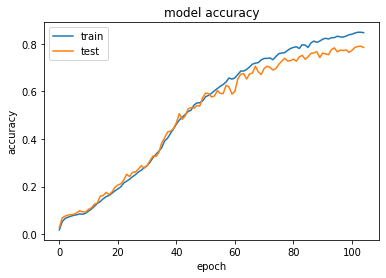

In [38]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

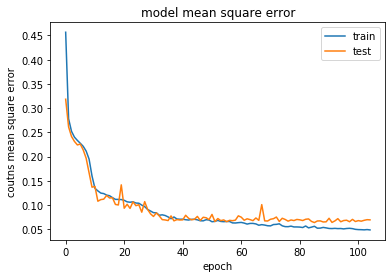

In [79]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model mean square error')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

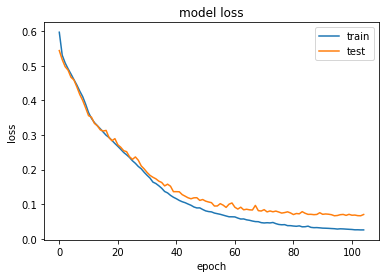

In [40]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Validando nos espectros criados com Penelope

In [41]:
from keras.utils.vis_utils import plot_model

In [42]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

373


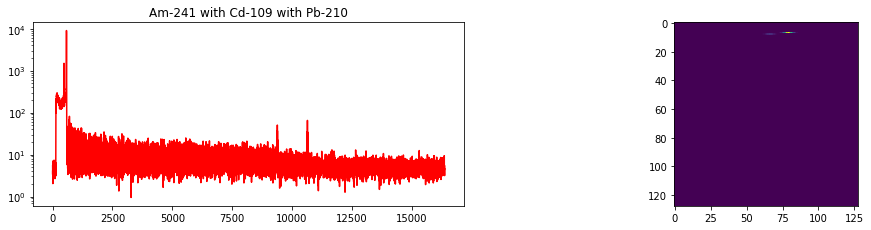

In [44]:
#idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

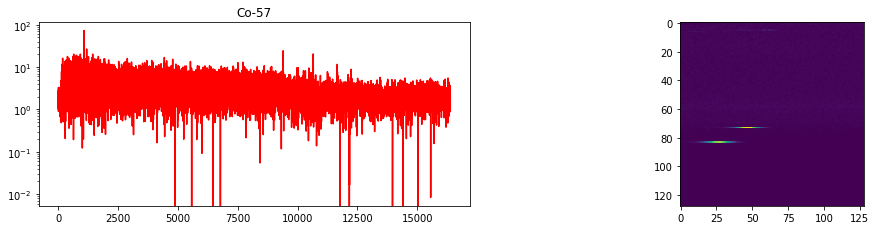

In [45]:
#idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
x_, aux_ = gerador_validacao[0]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [46]:
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

In [47]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': scaler.inverse_transform(y_counts[idx])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"16,505.34",0.00
1,Ba-133,1.95,"17,727.12",0.00
2,Cd-109,0.04,"3,495.48",0.00
3,Co-57,100.00,"51,672.64","47,635.95"
4,Co-60,0.00,"189,811.47",0.00
5,Cs-137,1.61,"9,694.85",0.00
6,Eu-152,1.08,"35,835.60",0.00
7,Mn-54,0.06,"65,226.24",0.00
8,Na-22,0.00,"201,972.28",0.00
9,Pb-210,0.00,"3,618.63",0.00


In [ ]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [48]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [49]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


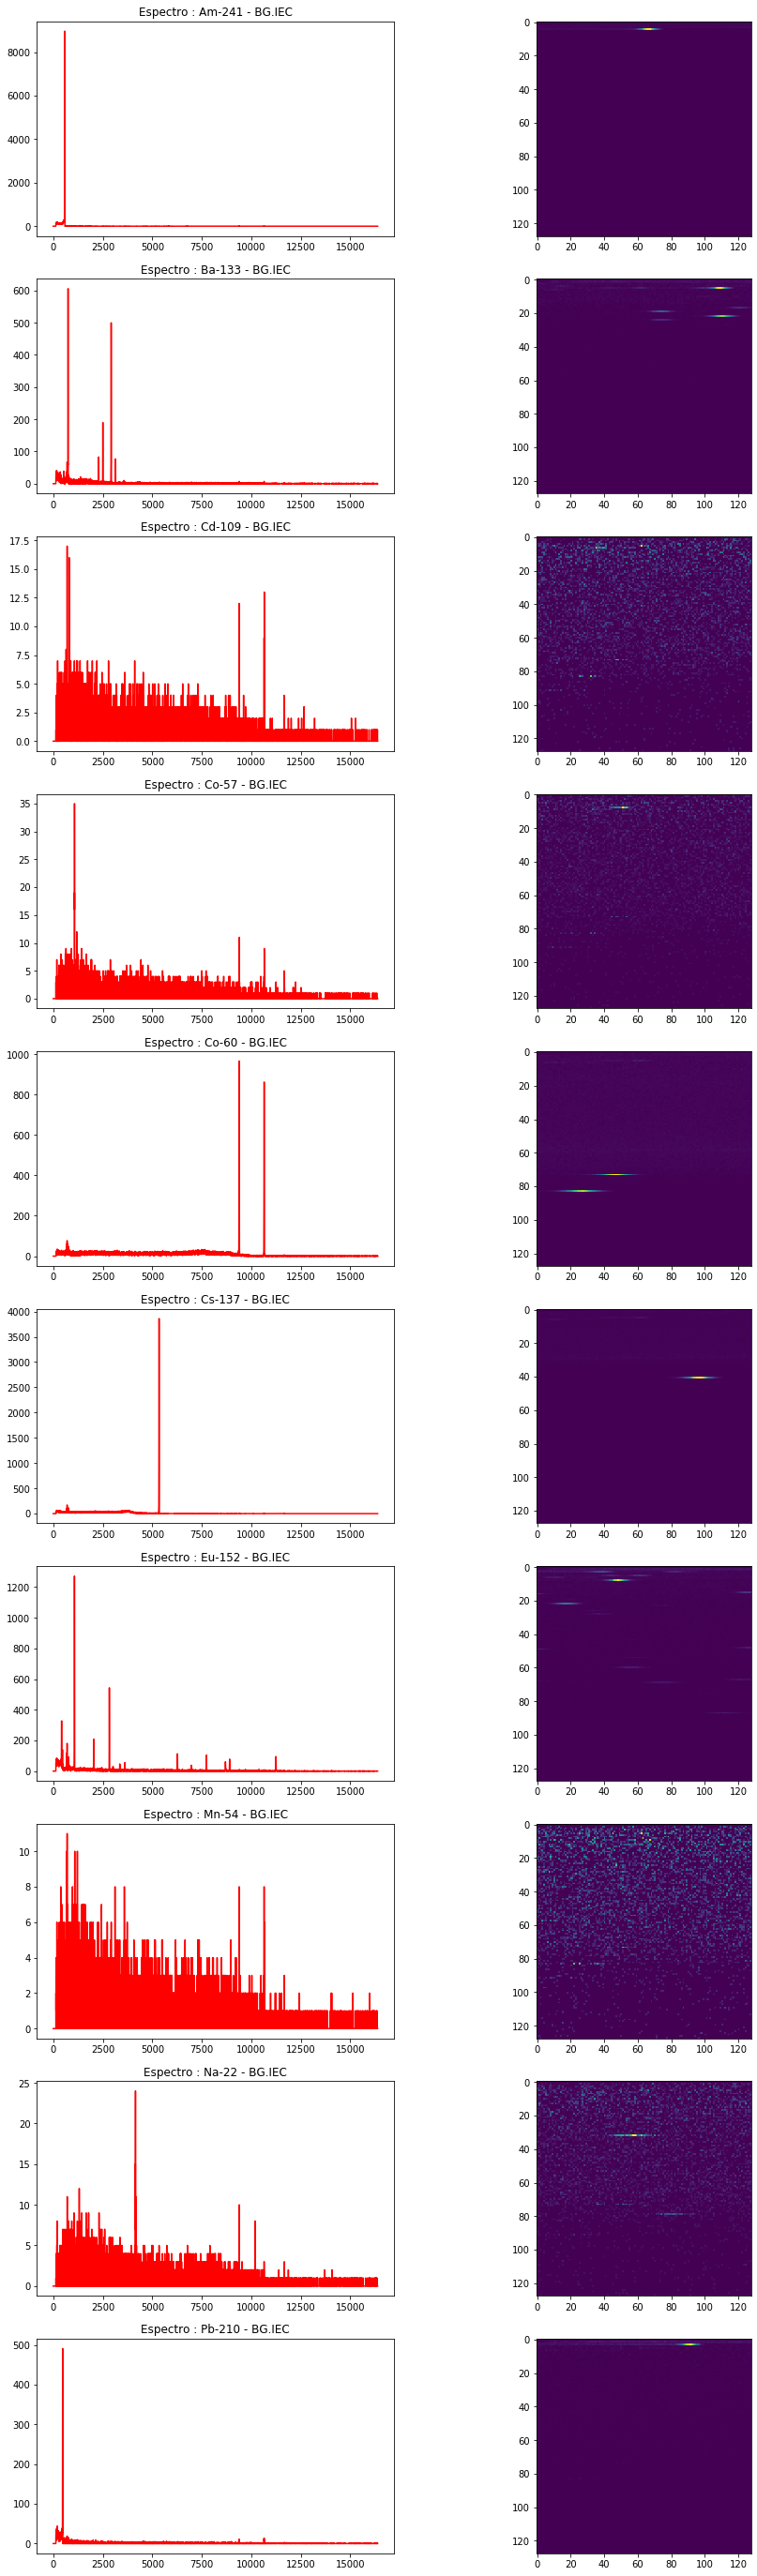

In [50]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [51]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"156,426.50","141,596.00"
1,Ba-133,2.07,"13,197.98","141,596.00"
2,Cd-109,0.45,"3,387.41","141,596.00"
3,Co-57,5.54,"6,590.37","141,596.00"
4,Co-60,0.00,"189,794.06","141,596.00"
5,Cs-137,1.72,"13,467.99","141,596.00"
6,Eu-152,0.99,"25,110.69","141,596.00"
7,Mn-54,0.05,"65,118.52","141,596.00"
8,Na-22,0.02,"201,700.78","141,596.00"
9,Pb-210,0.03,"3,613.45","141,596.00"


In [52]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.05,"16,479.31","35,319.00"
1,Ba-133,100.00,"39,449.93","35,319.00"
2,Cd-109,1.81,"3,131.51","35,319.00"
3,Co-57,2.05,"14,663.61","35,319.00"
4,Co-60,0.00,"189,811.34","35,319.00"
5,Cs-137,1.66,"19,402.59","35,319.00"
6,Eu-152,1.31,"11,471.19","35,319.00"
7,Mn-54,0.07,"65,111.92","35,319.00"
8,Na-22,0.09,"200,967.19","35,319.00"
9,Pb-210,0.09,"3,588.01","35,319.00"


In [53]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"16,505.33","7,195.00"
1,Ba-133,1.88,"6,143.05","7,195.00"
2,Cd-109,99.99,"19,298.28","7,195.00"
3,Co-57,5.49,"-5,655.69","7,195.00"
4,Co-60,0.82,"164,399.91","7,195.00"
5,Cs-137,1.44,"11,259.38","7,195.00"
6,Eu-152,0.79,"33,754.89","7,195.00"
7,Mn-54,0.18,"64,996.80","7,195.00"
8,Na-22,0.09,"200,689.78","7,195.00"
9,Pb-210,0.00,"3,617.24","7,195.00"


In [54]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"16,505.33","7,323.00"
1,Ba-133,2.79,"2,190.51","7,323.00"
2,Cd-109,0.31,"3,436.52","7,323.00"
3,Co-57,99.98,"14,473.68","7,323.00"
4,Co-60,0.00,"189,810.67","7,323.00"
5,Cs-137,1.36,"17,020.71","7,323.00"
6,Eu-152,0.91,"31,126.08","7,323.00"
7,Mn-54,0.17,"64,921.27","7,323.00"
8,Na-22,0.01,"201,846.05","7,323.00"
9,Pb-210,0.00,"3,618.62","7,323.00"


In [55]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"16,505.34","155,643.00"
1,Ba-133,0.00,"41,905.88","155,643.00"
2,Cd-109,0.23,"3,443.18","155,643.00"
3,Co-57,5.09,"3,472.07","155,643.00"
4,Co-60,100.00,"107,965.32","155,643.00"
5,Cs-137,1.53,"14,540.42","155,643.00"
6,Eu-152,1.83,"31,860.76","155,643.00"
7,Mn-54,0.23,"64,871.89","155,643.00"
8,Na-22,0.00,"201,968.67","155,643.00"
9,Pb-210,0.00,"3,617.96","155,643.00"


In [56]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.02,"16,493.31","188,461.00"
1,Ba-133,4.11,"15,090.79","188,461.00"
2,Cd-109,0.31,"3,416.18","188,461.00"
3,Co-57,3.88,"10,399.37","188,461.00"
4,Co-60,0.00,"189,811.47","188,461.00"
5,Cs-137,100.00,"198,555.69","188,461.00"
6,Eu-152,1.94,"1,644.08","188,461.00"
7,Mn-54,0.26,"64,505.88","188,461.00"
8,Na-22,0.04,"201,512.44","188,461.00"
9,Pb-210,0.07,"3,593.94","188,461.00"


In [57]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.18,"16,404.88","94,419.00"
1,Ba-133,6.77,"-5,945.65","94,419.00"
2,Cd-109,0.01,"3,498.65","94,419.00"
3,Co-57,2.01,"15,216.20","94,419.00"
4,Co-60,0.00,"189,811.47","94,419.00"
5,Cs-137,2.96,"3,250.70","94,419.00"
6,Eu-152,99.97,"86,994.60","94,419.00"
7,Mn-54,0.06,"65,219.30","94,419.00"
8,Na-22,0.12,"201,350.06","94,419.00"
9,Pb-210,0.11,"3,594.56","94,419.00"


In [58]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"16,505.34","7,159.00"
1,Ba-133,1.28,"12,888.04","7,159.00"
2,Cd-109,0.25,"3,360.61","7,159.00"
3,Co-57,5.75,"-11,465.79","7,159.00"
4,Co-60,0.00,"189,797.92","7,159.00"
5,Cs-137,1.49,"13,171.09","7,159.00"
6,Eu-152,0.87,"15,296.76","7,159.00"
7,Mn-54,98.52,"-17,092.71","7,159.00"
8,Na-22,0.37,"195,091.00","7,159.00"
9,Pb-210,0.00,"3,617.39","7,159.00"


In [59]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"16,505.34","7,965.00"
1,Ba-133,1.89,"6,557.14","7,965.00"
2,Cd-109,1.23,"2,957.67","7,965.00"
3,Co-57,3.34,673.25,"7,965.00"
4,Co-60,0.00,"189,810.33","7,965.00"
5,Cs-137,1.59,"15,704.39","7,965.00"
6,Eu-152,0.96,"11,993.52","7,965.00"
7,Mn-54,0.65,"64,100.19","7,965.00"
8,Na-22,100.00,"-141,030.98","7,965.00"
9,Pb-210,0.01,"3,614.88","7,965.00"


In [60]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,3.38,"14,311.39","19,650.00"
1,Ba-133,1.70,"19,210.14","19,650.00"
2,Cd-109,4.11,"2,970.16","19,650.00"
3,Co-57,3.13,"11,777.62","19,650.00"
4,Co-60,0.00,"189,800.44","19,650.00"
5,Cs-137,1.61,"10,584.02","19,650.00"
6,Eu-152,1.00,"23,227.98","19,650.00"
7,Mn-54,0.04,"65,212.70","19,650.00"
8,Na-22,0.03,"201,383.70","19,650.00"
9,Pb-210,100.00,"33,423.02","19,650.00"


## Fonte triplice de calibração

In [61]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

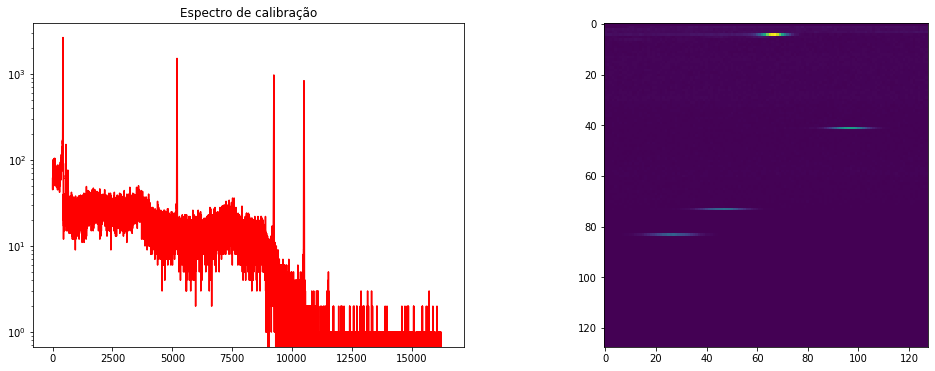

In [62]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [63]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,92.87,"37,888.34","276,428.00"
1,Ba-133,0.06,"41,697.98","276,428.00"
2,Cd-109,0.66,"3,575.78","276,428.00"
3,Co-57,11.65,"11,666.19","276,428.00"
4,Co-60,100.00,"239,932.05","276,428.00"
5,Cs-137,100.00,"54,813.89","276,428.00"
6,Eu-152,3.44,"57,431.24","276,428.00"
7,Mn-54,9.61,"55,650.43","276,428.00"
8,Na-22,0.00,"201,971.00","276,428.00"
9,Pb-210,0.11,"3,610.21","276,428.00"


In [64]:
37888.34 + 239932.05 + 54813.89

332634.28